In [89]:
# Kusama/USD daily (01/01/2021 - 09/09/2021): https://api.coingecko.com/api/v3/coins/kusama/market_chart/range?vs_currency=usd&from=1609459200&to=1631189591
# Bitcoin/USD daily (01/01/2021 - 09/09/2021): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1609459200&to=1631189591

# Kusama/USD hourly (26/03/2021 - 23/06/2021): https://api.coingecko.com/api/v3/coins/kusama/market_chart/range?vs_currency=usd&from=1616716800&to=1624406400
# Bitcoin/USD daily (26/03/2021 - 23/06/2021): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1616716800&to=1624406400

LIQUIDATION_THRESHOLD = 1.25

import json

def get_usd_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    return [price for (timestamp, price) in data["prices"]]

def determine_price_between_assets(asset_1_prices, asset_2_prices):
    return [asset_1_price / asset_2_price for (asset_1_price, asset_2_price) in zip(asset_1_prices, asset_2_prices)]

def prices_to_returns(prices):
    return [(prices[i]/prices[i - 1] - 1) for i in range(1, len(prices))]
  
kusama_to_usd_hourly = get_usd_timeseries("kusama_to_usd_hourly_Mar_Jun.json")
bitcoin_to_usd_hourly = get_usd_timeseries("bitcoin_to_usd_hourly_Mar_Jun.json")
ksm_to_btc_hourly = determine_price_between_assets(kusama_to_usd_hourly, bitcoin_to_usd_hourly)
ksm_to_btc_returns_hourly = prices_to_returns(ksm_to_btc_hourly)

kusama_to_usd_daily = get_usd_timeseries("kusama_to_usd_daily_2021.json")
bitcoin_to_usd_daily = get_usd_timeseries("bitcoin_to_usd_daily_2021.json")
ksm_to_btc_daily = determine_price_between_assets(kusama_to_usd_daily, bitcoin_to_usd_daily)
ksm_to_btc_returns_daily = prices_to_returns(ksm_to_btc_daily)

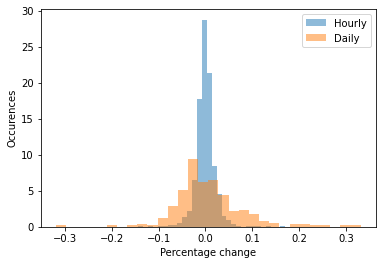

In [90]:
import matplotlib.pyplot as plt
import numpy as np

def plot_returns(returns, data_label):
    plt.hist(returns, density=True, bins=30, alpha=0.5, label=data_label)  # density=False would make counts
    plt.ylabel('Occurences')
    plt.xlabel('Percentage change')
    plt.legend(loc='upper right')

plot_returns(ksm_to_btc_returns_hourly, 'Hourly')
plot_returns(ksm_to_btc_returns_daily, 'Daily')

In [91]:
import statistics
confidence_99 = 2.33
confidence_95 = 1.64
# Compute stddev using the daily returns, as these have higher volatility
# VaR occasionally underestimates the number of large market moves.
# Could consider a higher confidence interval to be on the safe side
std_dev = statistics.pstdev(ksm_to_btc_returns_daily)
expected_loss_percentage_99 = confidence_99 * std_dev
expected_loss_percentage_95 = confidence_95 * std_dev
print("99% confidence interval max price drop (%): " + str(expected_loss_percentage_99 * 100))
required_collateralization_99 = LIQUIDATION_THRESHOLD / (1 - expected_loss_percentage_99)
required_collateralization_95 = LIQUIDATION_THRESHOLD / (1 - expected_loss_percentage_95)
print("Liquidation threshold assumption: " + str(LIQUIDATION_THRESHOLD))
print("Required collateralization (99% confidence interval): " + str(required_collateralization_99))
print("Required collateralization (95% confidence interval): " + str(required_collateralization_95))


99% confidence interval max price drop (%): 17.024958983377694
Liquidation threshold assumption: 1.25
Required collateralization (99% confidence interval): 1.5064771100861387
Required collateralization (95% confidence interval): 1.4201839509072898
